# Part 3 - Using x-vectors as embeddings for classification tasks

In this section, you will learn how to use speech embedding models to perform speech classification tasks.

You will be working in a Google Colab environment.

A few important notes:

* Make sure to copy this notebook to your own drive so your progress is saved.
* Change the runtime type to GPU to achieve faster inference with our embedding model. (To do this, click on 'Runtime' → 'Change runtime type' in the toolbar.)
* You can add any necessary imports (e.g., when selecting classifiers) across different code cells.

## Imports

In [1]:
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 33.4 MB/s eta 0:00:00


In [2]:
import os
import torch
import random
import librosa
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from speechbrain.inference.classifiers import EncoderClassifier

device = "cuda" if torch.cuda.is_available() else "cpu"

## 3.1 - SPEECHCOMMANDS Dataset

The SPEECHCOMMANDS dataset consists of approximately 2,000 speakers and around 100,000 utterances.

The code below downloads both the training and validation splits.

In [3]:
# DS loading - takes aprroximately 2-3 mins, be patient.
dataset_train = torchaudio.datasets.SPEECHCOMMANDS(
    root="./",
    download=True,
    subset="training"
)

100%|██████████| 2.26G/2.26G [00:18<00:00, 133MB/s]


The code below loads the embedding model to the device, and sets model mode to evaluation.

In [4]:
# Given code
xvector_model = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="./")
xvector_model.device = device
xvector_model.to(device)
xvector_model.eval()

hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

EncoderClassifier(
  (mods): ModuleDict(
    (compute_features): Fbank(
      (compute_STFT): STFT()
      (compute_fbanks): Filterbank()
      (compute_deltas): Deltas()
      (context_window): ContextWindow()
    )
    (mean_var_norm): InputNormalization()
    (embedding_model): ECAPA_TDNN(
      (blocks): ModuleList(
        (0): TDNNBlock(
          (conv): Conv1d(
            (conv): Conv1d(80, 1024, kernel_size=(5,), stride=(1,))
          )
          (activation): ReLU()
          (norm): BatchNorm1d(
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): SERes2NetBlock(
          (tdnn1): TDNNBlock(
            (conv): Conv1d(
              (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
            )
            (activation): ReLU()
            (norm): BatchNorm1d(
              (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
     

## 3.2 - Speaker Classification

Each sample on the file tree of SPEECHCOMMANDS includes a unique speaker id.

The below code extracts all the speaker ids in the dataset to `spkr_ids` list.

In [5]:
# Given code
wav_paths = [os.path.join(root, file) for root, dirs, files in os.walk('./SpeechCommands/speech_commands_v0.02') for file in files if file.endswith('.wav')]
spkr_ids = list({os.path.basename(wav_path).split('_')[0] for wav_path in wav_paths})

### 3.2.1 - t-SNE Projection

t-SNE projection is similar to PCA. We will use it to visualize how our embedding model maps the speech files onto a space relevant to our task.

You can read more about t-SNE here:
https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne

And about sklearn's TSNE implementation here:
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

There is no need to dive deeply into the implementation or technical details of t-SNE, but feel free to explore further and broaden your horizons. :)

In this section, you will gain an understanding of how x-vector embeddings map speech data onto another latent space.

Follow these instructions:

1. Select 10 speakers from the spkr_ids list. Choose speakers with more than 100 utterances, and ensure all selected speakers have a similar number of samples.
1. For the chosen speakers, create a list of all wav files associated with them (across all different classes).
1. Ensure your list contains at least 1,000 wav files, with an even distribution of samples across speakers.
1. For each wav file in the list, extract its embedding and the corresponding spkr_id label.
1. Generate a scatter plot showing the t-SNE projection of the extracted embeddings. Assign a unique color to each speaker's data points on the scatter plot.

**Hint**: Use two lists while generating the embeddings—one for the embeddings and another for the speaker IDs.

**Notes**:
* Use a 2-dimensional t-SNE projection.
* Include an appropriate title and labels for the axes in the plot.

0) i.d: 5a5721f8: files: 117
1) i.d: 964e8cfd: files: 109
2) i.d: 61abbf52: files: 102
3) i.d: 471a0925: files: 101
4) i.d: 29dce108: files: 123
5) i.d: d278d8ef: files: 104
6) i.d: 42a99aec: files: 127
7) i.d: ace072ba: files: 127
8) i.d: b69fe0e2: files: 117
9) i.d: 35d1b6ee: files: 101
as we can see, the speakers are about evenly distributed in terms of wav files per-speaker
the number of total recordings is 1128>1000


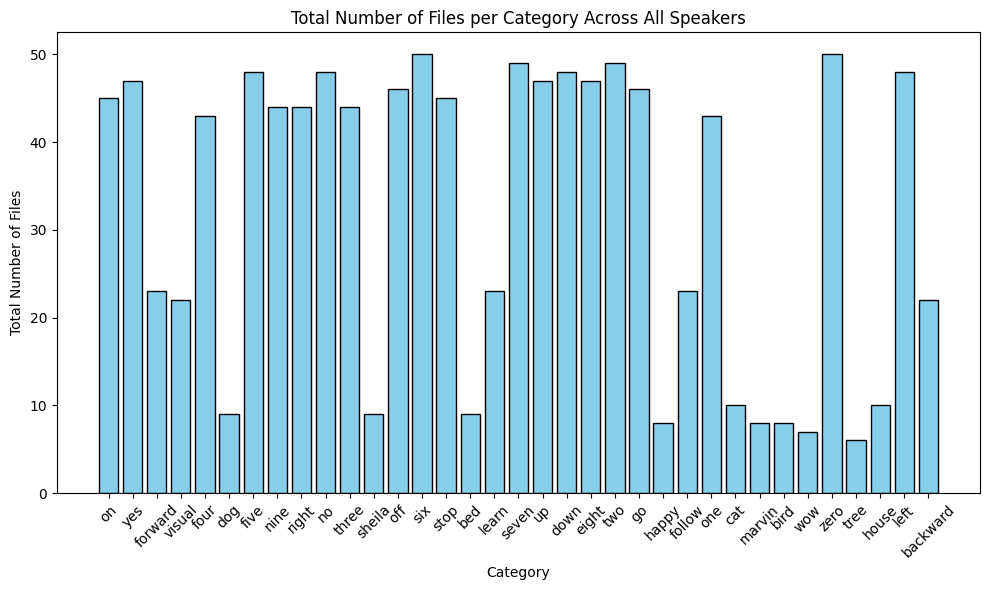

Embeddings shape: (1128, 192)


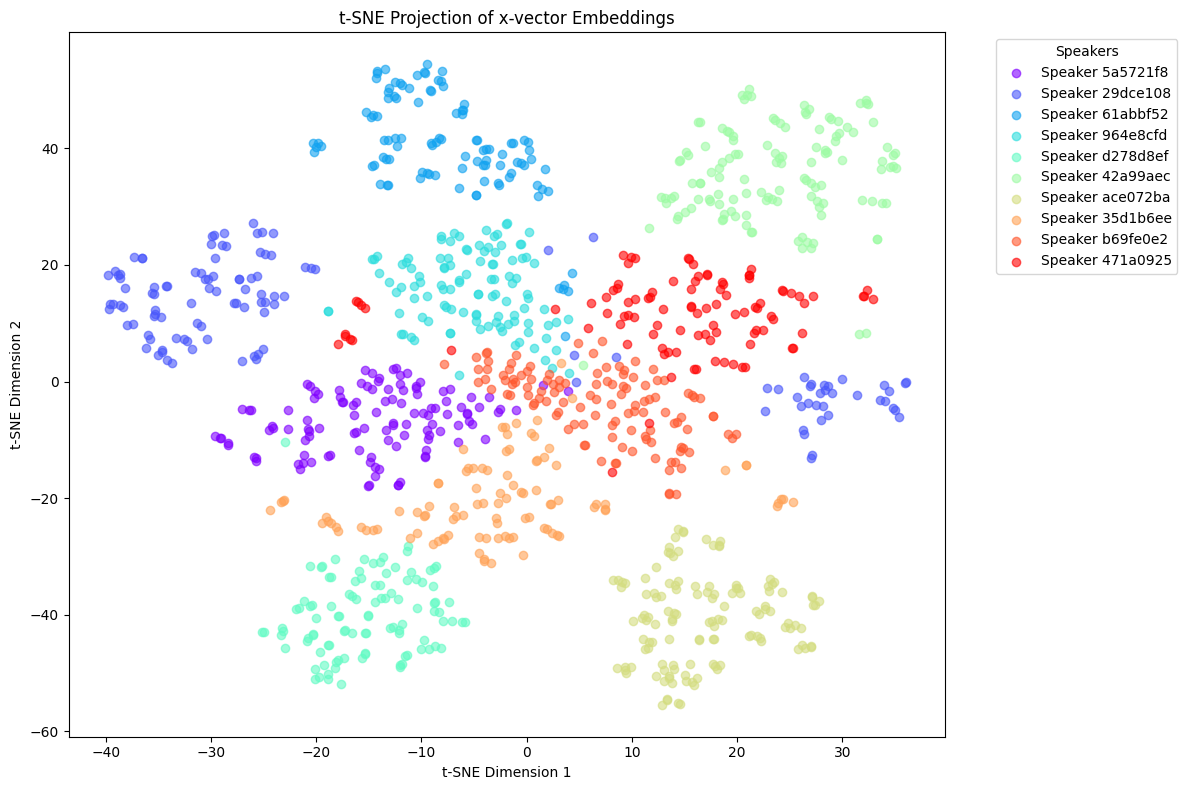

In [6]:
from collections import defaultdict
from collections import Counter
# Extract spkr_ids from file paths
spkr_ids_from_files = [os.path.basename(wav_path).split('_')[0] for wav_path in wav_paths]

# Count occurrences of each spkr_id
spkr_counts = Counter(spkr_ids_from_files)

# SELECTING SPEAKERS
eligible_speakers = []
for spkr_id, wavcount in spkr_counts.items():
    if wavcount >= 100 :
        eligible_speakers.append(spkr_id)


selected_speakers = eligible_speakers[:10]
for i,speaker in zip(range(10),selected_speakers):
  print(f"{i}) i.d: {speaker}: files: {spkr_counts[speaker]}")
print("as we can see, the speakers are about evenly distributed in terms of wav files per-speaker")

# Filter wav files for selected speakers
filtered_wav_files = [
    wav_path for wav_path in wav_paths
    if os.path.basename(wav_path).split('_')[0] in selected_speakers
]

category_counts = defaultdict(int)

for path in filtered_wav_files:
  category = os.path.basename(os.path.dirname(path))
  category_counts[category] += 1

# plotting a bar graph
categories = list(category_counts.keys())
counts = list(category_counts.values())

print(f"the number of total recordings is {np.sum(counts)}>1000")

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue', edgecolor='black')
plt.xlabel('Category')
plt.ylabel('Total Number of Files')
plt.title('Total Number of Files per Category Across All Speakers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# scatter plot for t-SNE

filtered_wav_files = [
    wav_path for wav_path in wav_paths
    if os.path.basename(wav_path).split('_')[0] in selected_speakers
]
import torch
from speechbrain.inference.classifiers import EncoderClassifier
device = "cuda" if torch.cuda.is_available() else "cpu"
# load embedding model to selected device


embeddings = []
labels = []

for wav_path in filtered_wav_files:
    # Extract speaker ID
    spkr_id = os.path.basename(wav_path).split('_')[0]
    labels.append(spkr_id)

    # Load audio and extract embedding
    signal, rate = torchaudio.load(wav_path)
    signal = signal.to(device)  # Assuming `device` is defined (e.g., "cuda" or "cpu")
    embedding = xvector_model.encode_batch(signal).squeeze(0).detach().cpu().numpy()
    embeddings.append(embedding)

# Ensure embeddings are flattened to 2D
embeddings = np.array([embedding.flatten() for embedding in embeddings])

# Verify the shape of embeddings (should be 2D: n_samples x n_features)
print(f"Embeddings shape: {embeddings.shape}")

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Proceed with plotting as described earlier
unique_labels = list(set(labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(12, 8))
for i, label in enumerate(unique_labels):
    indices = [j for j, lbl in enumerate(labels) if lbl == label]
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1],
                label=f"Speaker {label}", color=colors[i], alpha=0.6)

# Add title, labels, and legend
plt.title('t-SNE Projection of x-vector Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title="Speakers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 3.2.2 - Classify Speakers

On this section, you will classify different speakers using embeddings from our embedding model.

1. Collect wav files of **20** different speakers. (Follow the same guidelines from 3.2.1.1).
1. Choose three different classifiers from `sklearn` library (e.g., SVM, Decision Tree, Random Forest, LDA, etc.)
1. Add a table of the results, using 5-Fold Crossv-Validation (CV) as specified in the exercise PDF. Discuss the results.

**Note**: Present mean and standard-deviation of classification results per each classifier.


In [7]:
selected_20 = []
for spkr_id, wavcount in spkr_counts.items():
    if wavcount >= 100 and wavcount <=115 and len(selected_20)<20 :
        selected_20.append(spkr_id)

for i,speaker in zip(range(20),selected_20):
  print(f"{i}) i.d: {speaker}: files: {spkr_counts[speaker]}")
print("as we can see, the speakers are about evenly distributed in terms of wav files per-speaker")


from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

embeddings = []
labels = []

# Extract embeddings for filtered WAV files
for wav_path in filtered_wav_files:
    spkr_id = os.path.basename(wav_path).split('_')[0]
    signal, rate = torchaudio.load(wav_path)
    signal = signal.to(device)
    embedding = xvector_model.encode_batch(signal).squeeze(0).detach().cpu().numpy()
    embeddings.append(embedding.flatten())
    labels.append(spkr_id)

# Convert to numpy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

# Define classifiers
classifiers = {
    "SVM": SVC(kernel='linear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Perform 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {name: [] for name in classifiers.keys()}

for train_index, test_index in kf.split(embeddings):
    X_train, X_test = embeddings[train_index], embeddings[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name].append(acc)

# Compute mean and standard deviation
results_summary = {
    name: {"Mean Accuracy": np.mean(scores), "Std Dev": np.std(scores)}
    for name, scores in results.items()
}

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results_summary).T
print(results_df)



0) i.d: 964e8cfd: files: 109
1) i.d: 61abbf52: files: 102
2) i.d: 471a0925: files: 101
3) i.d: d278d8ef: files: 104
4) i.d: 35d1b6ee: files: 101
5) i.d: 324210dd: files: 113
6) i.d: 18f8afd5: files: 103
7) i.d: 2e75d37a: files: 110
8) i.d: 888a0c49: files: 106
9) i.d: ab9b93e4: files: 100
10) i.d: c948d727: files: 108
11) i.d: a55105d0: files: 110
12) i.d: b8874962: files: 114
13) i.d: 686d030b: files: 100
14) i.d: 8134f43f: files: 110
15) i.d: a2cc5444: files: 111
16) i.d: 91b03183: files: 112
17) i.d: 4fd1443e: files: 114
18) i.d: 15dd287d: files: 115
19) i.d: 1496195a: files: 113
as we can see, the speakers are about evenly distributed in terms of wav files per-speaker
               Mean Accuracy   Std Dev
SVM                 0.986694  0.005628
Decision Tree       0.493794  0.021195
Random Forest       0.941499  0.008985


## 3.3 - Command Classification

The SPEECHCOMMANDS dataset was originally created to train speech models for classifying different commands.

In this section, we will evaluate our embedding model on a command classification task.

### 3.3.1 - t-SNE Projection



Repeat the process from Section 3.2.1, but this time use the commands as labels in the t-SNE projection.

1. Select only **three** commands from the following set: {left, happy, marvin, go, zero, right}.
1. Randomly select 1,000 samples for each chosen command.
1. This should result in a dataset of 3,000 samples, divided into three classes (the three commands you chose), with 1,000 samples per command.
1. Generate a scatter plot of the t-SNE projection and discuss the results in your report.

Embeddings shape: (3000, 192)


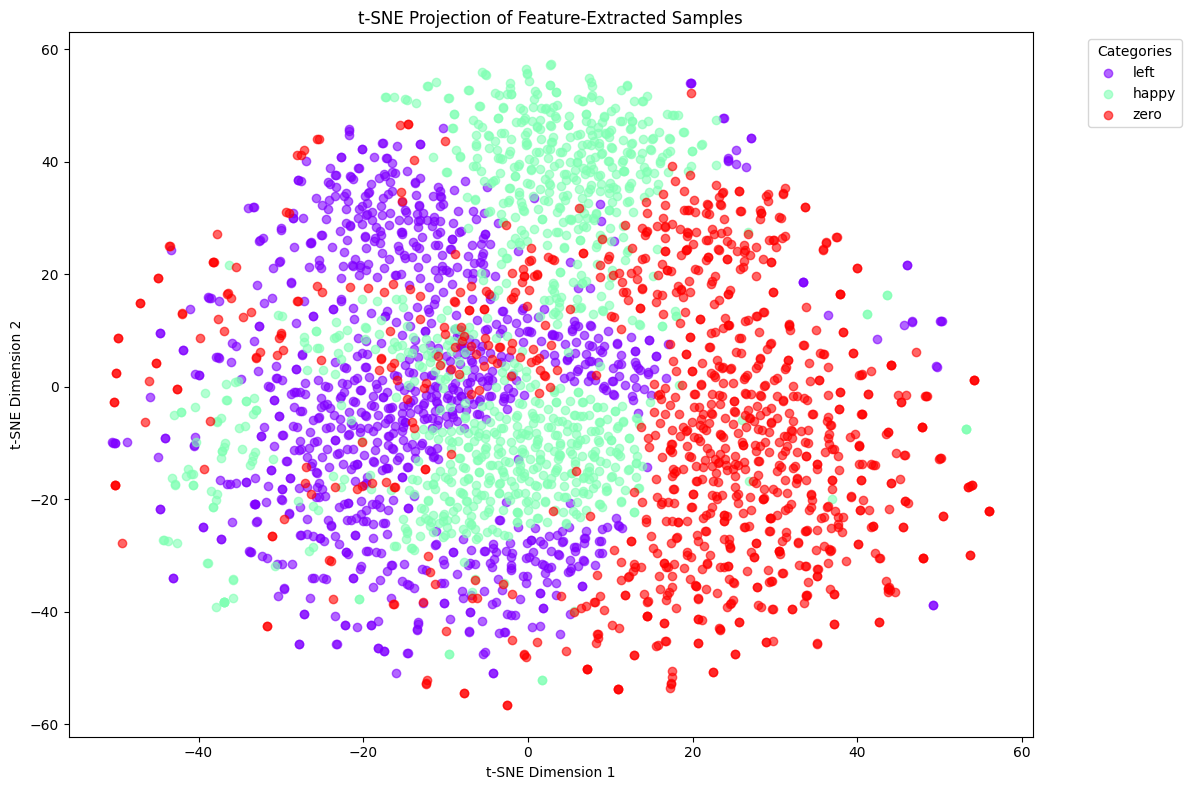

In [10]:
# Initialize lists for each category
left_wavs = []
happy_wavs = []
zero_wavs = []

# Traverse the directory structure
for root, dirs, files in os.walk('./SpeechCommands/speech_commands_v0.02'):
    # Check the current directory name
    dir_name = os.path.basename(root)

    # Iterate over the files in the directory
    for file in files:
        if file.endswith('.wav'):  # Process only WAV files
            file_path = os.path.join(root, file)
            if dir_name == 'left':
                left_wavs.append(file_path)
            elif dir_name == 'happy':
                happy_wavs.append(file_path)
            elif dir_name == 'zero':
                zero_wavs.append(file_path)
num_samples = 1000

# Ensure each list has at least 1,000 samples and then select them randomly
left_samples = random.sample(left_wavs, min(len(left_wavs), num_samples))
happy_samples = random.sample(happy_wavs, min(len(happy_wavs), num_samples))
zero_samples = random.sample(zero_wavs, min(len(zero_wavs), num_samples))



# Assuming embeddings and labels are extracted for the three categories
# left_samples, happy_samples, zero_samples are the lists of file paths for each category

categories = ["left", "happy", "zero"]
samples = [left_samples, happy_samples, zero_samples]

# Extract embeddings and labels for t-SNE
embeddings = []
labels = []

for category, sample_list in zip(categories, samples):
    for wav_path in sample_list:
        # Extract embedding
        signal, rate = torchaudio.load(wav_path)
        signal = signal.to(device)
        embedding = xvector_model.encode_batch(signal).squeeze(0).detach().cpu().numpy()
        embeddings.append(embedding.flatten())  # Ensure the embedding is 1D
        labels.append(category)  # Label corresponds to the category

# Convert embeddings to numpy array
embeddings = np.array(embeddings)

# Verify shape
print(f"Embeddings shape: {embeddings.shape}")

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Plot t-SNE results
unique_labels = categories  # ["left", "happy", "zero"]
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(12, 8))
for i, label in enumerate(unique_labels):
    indices = [j for j, lbl in enumerate(labels) if lbl == label]
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1],
                label=label, color=colors[i], alpha=0.6)

# Add title, labels, and legend
plt.title('t-SNE Projection of Feature-Extracted Samples')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()





### 3.3.2 - Classify Commands

Repeat the process from Section 3.2.2, but this time use commands as labels for classification.

1. Use the embeddings from Section 3.3.1 to classify the different classes.
1. Display a table of the classification results and discuss your findings in the report.


**Note**: Present the classification results using 5-fold cross-validation (CV).

**Note**: Present mean and standard-deviation of classification results per each classifier.

In [11]:
# Define classifiers
classifiers = {
    "SVM": SVC(kernel='linear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Initialize results dictionary
results = {name: [] for name in classifiers.keys()}

# Perform 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(embeddings):
    X_train, X_test = embeddings[train_index], embeddings[test_index]
    y_train, y_test = np.array(labels)[train_index], np.array(labels)[test_index]

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name].append(acc)

# Compute mean and standard deviation for each classifier
results_summary = {
    name: {"Mean Accuracy": np.mean(scores), "Std Dev": np.std(scores)}
    for name, scores in results.items()
}

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results_summary).T
print(results_df)

               Mean Accuracy   Std Dev
SVM                 0.882000  0.014040
Decision Tree       0.557000  0.021119
Random Forest       0.863667  0.007846


### Good Luck!